# TD 5: Transformers for computer vision
By Nicolas Dufour, Vicky Kalogeiton and Pascal Vannier

In this TD, we will implement the Transformers architecture. Transformers has been a key architecture in deep learning for the past 5 years.

It has first began with NLP, then came audio and finally, since 2020, computer vision.
We will implement every block that makes a transformer from scratch and we will try to create a deep understanding of what is happening.
Here is a diagram for the transformer architecture:

<img src="https://www.researchgate.net/profile/Miruna-Gheata/publication/355339249/figure/fig1/AS:1079476452622337@1634378650979/Encoder-decoder-architecture-of-the-Transformer-developed-by-Vaswani-et-al-28.ppm" width=768>

## Instructions
As stated before, in pytorch you must achieve for loops at all cost. It's almost always possible to find a vectorized version of the operation you want to implement.
In this TP, the only for-loop you can do is the training loop.

In [90]:
!pip install einops
!pip install timm

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import math
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import timm



## The Transformer model from the paper Attention is All You Need.

### Attention

The transformer architecture is built around one key block: The attention.
The idea behind attention is the following. Imagine you want to retrieve information from a dictionary. The dictionnary is indexed by keys which maps to a particular value. Now, you have a query which will be matched against the keys of the dict and if you have a match, you will retrieve the associated value.
Attention is very similar to this simple retrieval example. Now, with real data, we don't have this structure, we however are going to learn to create it.

We have 2 sets of vectors (also named tokens). One is $X_{to}$ which is the destination set. We want to be able to map this set of tokens to queries. We achieve this by doing a linear projection of $X_{to}$. $Q = W_QX_{to}$

The other set is $X_{from}$ the set from which we want to retrieve information. We will need to extract both keys and values from this set. We therefore do 2 linear projections of $X_{from}$. $K = W_KX_{from}$ and $V = W_VX_{from}$.

Now, contrary to the dictionnary where queries and values are exact matchs, we don't have this here. Therefore, we will perform a softer match by computing the similarity matrix between $Q$ and $K$. Then for each $Q$, we want to output the values that have the higher similarity. We therefore output the weighted sum of the values, weighted by the softmax of the similarity (also called the attention matrix).

Finally, the attention operation is given by the cross attention:

$$
A(Q,K,V) = SoftMax(\frac{Q^TK}{\sqrt{d_k}})V
$$

We divide the similarity by $\sqrt{d_k}$ for stability reason to avoid the similarity to explode with big vectors which would lead to very sharp attention coeficients.

##### Question 1:
Implement the attention operation.

Tip: Look into `torch.einsum` to easily compute the similarity matrix, an easy to understand explanation may be found [here](https://rockt.github.io/2018/04/30/einsum).


In [92]:
class Attention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim):
        super().__init__()
        self.x_to_dim = x_to_dim
        self.x_from_dim = x_from_dim
        self.hidden_dim = hidden_dim
        self.query_projection = nn.Linear(x_to_dim, hidden_dim)
        self.value_projection = nn.Linear(x_from_dim, hidden_dim)
        self.key_projection = nn.Linear(x_from_dim, hidden_dim)

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        query = self.query_projection(x_to) 
        key = self.key_projection(x_from) 
        value = self.value_projection(x_from) 
        
        product = torch.einsum('b i d, b j d -> b i j', query, key)/math.sqrt(self.hidden_dim)
        weights = F.softmax(product, dim=2)
        out = torch.einsum('b i j, b j d -> b i d', weights, value) # [batch size, x_to_len, hidden_dim]
        return out
        

#### Multi-head attention

We improve the above attention implementation by introducing mult-head attention. The idea here is that we compute the attention on subspaces of the $Q,K,V$ triplets.
We split each vector in n subsets and compute the attention for each subset. At the end, we concatenate every attention output and project it with an output projection.

##### Question 2
Implement Multihead attention.

In [93]:
class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super().__init__()
        self.x_to_dim = x_to_dim
        self.x_from_dim = x_from_dim
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.query_projection = nn.Linear(x_to_dim, hidden_dim)
        self.key_projection = nn.Linear(x_to_dim, hidden_dim)
        self.value_projection = nn.Linear(x_to_dim, hidden_dim)

    
    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        
        batch_size = x_to.size(0)
        x_to_len = x_to.size(1)
        x_from_len = x_from.size(1)

        query = self.query_projection(x_to)  
        key = self.key_projection(x_from)  
        value = self.value_projection(x_from) 
        
        query = query.view(batch_size, x_to_len, self.n_heads, self.hidden_dim // self.n_heads).transpose(1, 2)  # [batch size, n_heads, x_to_len, hidden_dim // n_heads]
        key = key.view(batch_size, x_from_len, self.n_heads, self.hidden_dim // self.n_heads).transpose(1, 2)  # [batch size, n_heads, x_from_len, hidden_dim // n_heads]
        value = value.view(batch_size, x_from_len, self.n_heads, self.hidden_dim // self.n_heads).transpose(1, 2)  # [batch size, n_heads, x_from_len, hidden_dim // n_heads]

        attention_scores = torch.einsum('b h i d, b h j d -> b h i j', query, key)  # [batch size, n_heads, x_to_len, x_from_len// n_heads]
        attention_scores = attention_scores / math.sqrt(self.hidden_dim // self.n_heads)  
        attention_probs = F.softmax(attention_scores, dim=-1)  # [batch size, n_heads, x_to_len, x_from_len]
        
        attended_values = torch.einsum('b h i j, b h j d -> b h i d', attention_probs, value)  # [batch size, n_heads, x_to_len, hidden_dim // n_heads]
        
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, x_to_len, self.hidden_dim)  # [batch size, x_to_len, hidden_dim]

        output = self.output_projection(attended_values)  # [batch size, x_to_len, x_to_dim]
        
        return output
            
        


MultiheadAttention is the attention that is used in transformers in pratice. It is used in 2 flavors:
- Self Attention: When $X_{to}$ attends itself ($X_{to}=X_{from}$)
- Cross Attention. $X_{to}\neq X_{from}$


##### Question 3: Implement MultiHead Self Attention and MultiHeadCrossAttention from Multihead attention

In [94]:
class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, x_to_dim, hidden_dim, n_heads):
        super().__init__(x_to_dim, x_to_dim, hidden_dim, n_heads)
    
    def forward(self, x):
        return super().forward(x, x)
    
    
class MultiHeadCrossAttention(MultiHeadAttention):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super().__init__(x_to_dim, x_from_dim, hidden_dim, n_heads)
    
    def forward(self, x_to, x_from):
        return super().forward(x_to, x_from)
    

### LayerNorm
Another key component of the transformer is the LayerNorm. As we have previously seen, normalizing the output of a deep learning layer helps a lot with convergence and stability.
Until Transformers, the most used normalization is BatchNorm. We normalize the data among the batch dimension. However, this has a few problems.
- The normalization depend on the other samples in the batch
- When using multiple GPUs, BatchNorm needs to synchronize the batch statistic across GPUs, which locks the forward process and slow down training.

The last element is the most important one. Transformers, aims to be a easy to parralilize architecture and can't afford to use batchnorm.

Instead, Transformers uses Layer Norm. LayerNorm is sample dependent, which removes the synchronization issue. We normalize over the channel dimension instead of the batch dimension.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png">

To account for the loss of capacity, we map the output by a linear transformation with a learned bias and scale.

##### Question 4:
Implement the LayerNorm

In [95]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_dim, eps=1e-5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(hidden_dim))
        self.beta = nn.Parameter(torch.zeros(hidden_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

### Feed Feedward Network

Finally, the last block is a feed-forward network with one hidden layer. This layer has usually a size of $2 * input\_dim$. This is followed by a dropout layer and an activation function. Here, we will use leaky relu, with a leak parameter of 0.1.
##### Question 5: Implement the FFN layer

In [96]:
class FFN(nn.Sequential):
    def __init__(self, hidden_dim, dropout_rate=0.1, expansion_factor=2):
        super().__init__()
        self.add_module('linear1', nn.Linear(hidden_dim, hidden_dim * expansion_factor))
        self.add_module('dropout', nn.Dropout(dropout_rate))
        self.add_module('activation', nn.LeakyReLU(0.1))
    def forward(self, x):
        return super().forward(x)
        

### The Transformer block

The last thing that we are missing are the skip connection. Like in ResNet, the transformer architecture implements the skip-connection. This allow for a better gradient flow avoiding vanishing gradient.
There is a skip connection after the attention and the feed forward network

##### Question 6.
Looking at the transformer figure, implement the Transformer Encoder Block


In [97]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,data_dim, hidden_dim, n_heads, dropout_rate=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(data_dim, hidden_dim, n_heads)
        self.norm1 = LayerNorm(hidden_dim)
        self.ffn = FFN(hidden_dim, dropout_rate)
        self.norm2 = LayerNorm(hidden_dim)


    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        attended = self.norm1(self.attention(x) + x)
        output = self.norm2(self.ffn(attended) + attended)
        return output
        
        

### Positional embedding
The transformers architecture is permutation independent. That means that for every token, we can swap 2 tokens and have the exact same result. However, the position of the token can be a very important information to consider. Imagine in an image. If a pixel is nearby another pixel, we want the transformer to be able to capture such information. Which is not the case for now.
That's why we introduce positional encodings. For each token, add the positional encoding to the original token:

$$
X_i = X_i + PE(i)
$$

with X_i the token at the i dimension.

The most used positional encodings are sinusoidal encodings. They are defined as follow:

$$
PE(i, 2j) = sin(i / 10000^{\frac{2j}{d}}) \\
PE(i, 2j + 1) = cos(i / 10000^{\frac{2j}{d}})
$$

Where $d$ the dimension of the tokens, $i$, the i-th token in the sequence and $2j$ (resp $2j + 1$), the index of the dimension of the vector.
The idea here is that we add a sinusoidal that encode the position in a multidimensional array.

Another common positional encodings is the learned positional encoding. Simply, we let the network learn a set of tensor $PE$ that match the sequence length and dimension of the tokens.

##### Question 7.

Implement both Sinusoidal and Learned positional embeddings

In [98]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        pos = torch.arange(0, x.size(1), device=x.device).float()
        dim = torch.arange(0, x.size(2), device=x.device).float()
        dim = 2 * (dim // 2)
        angles = pos.unsqueeze(-1) / (10000 ** (dim / self.hidden_dim))
        pos_enc = torch.zeros_like(x)
        pos_enc[:, :, 0::2] = torch.sin(angles)
        pos_enc[:, :, 1::2] = torch.cos(angles*10000)
        return x + pos_enc

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, hidden_dim)
    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        pos = torch.arange(0, x.size(1), device=x.device)
        pos_enc = self.position_embeddings(pos)
        return x + pos_enc

### The transformer encoder
Now you have everything you need to implement the transformer . You add positional encoding to the tokens and then stack N transformer encoder layers

##### Question 8.
Implement the transformer encoder with n_layers and the ability to choose both positional embeddings.

Tip: Look into `ModuleList`

In [99]:
class TransformerEncoder(nn.Module):
    def __init__(self, data_dim,  hidden_dim, n_heads, n_layers, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderBlock(data_dim, hidden_dim, n_heads, dropout_rate) for _ in range(n_layers)])
        if positional_encoding == "sinusoidal":
            self.positional_encoding = SinusoidalPositionalEncoding(hidden_dim)
        elif positional_encoding == "learned":
            self.positional_encoding = LearnedPositionalEncoding(hidden_dim, max_len)
        else:
            raise ValueError("positional_encoding should be 'sinusoidal' or 'learned'")
    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x)
        return x

## The Vision Transformer
The above architecture was introduced in 2017 to process sequences of text tokens. However, it could be useful to be able to leverage this architecture for computer vision. On the contrary of convolutional neural network, the transformer has the advantage to introduce less inductive bias.

This could be interesting to leverage to improve vision systems. If we learn the biases from the data, we can hope to have better performances. We however need compute and a lot of data to do this.

To apply the transformer to images, one key question remains to be answered: How do we transform an image to tokens? The approach introduce in Vision Transformers is to cut the image into patches that are then transformed into a token trhought a linear projection.

We also add an extra token, known as the classification token, that will be the token which will be use to predict upon. After going through the N transformer layers, this is the token that goes throught a multi layer perceptron.


<img src= "https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s1600/image1.gif" width="512">


##### Question 9

Implement the vision transformer

Hint: Use Conv2D with the right kernel size and stride to do the linear projection of non-overlapping patches.

In [100]:
class ViT(nn.Module):
    def __init__(self, patch_size, hidden_dim, n_heads, n_layers, n_classes, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        self.positional_encoding = positional_encoding
        self.max_len = max_len
        self.patch_embedding = nn.Linear(3 * patch_size ** 2, hidden_dim)
        self.transformer = TransformerEncoder(hidden_dim, hidden_dim, n_heads, n_layers, dropout_rate, positional_encoding, max_len)
        self.classification_head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        # x = [batch size, 3, image size, image size]
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.classification_head(x)
        return x

## BONUS What is my transformer doing? Visualizing the attention matrices
Transformers offer a great tool for visualisation. Indeed, we can look at the attention matrices to see what is our attention block looking at. This allows to visualise what data is the transformer paying attention. It could be super useful to identify biases on which the network has been focusing.

Imagine you want to classify dogs and cats, but in your training data dogs always have a red collar. When you use your classifier on a cat with a red collar it classifies it as a dog! Looking at the attention matrix you can see that the transformer just look at the cats collar and doesn't pay attention to cat itself. You just have identified a bias in your data! You can now fix it by collecting data of dogs without collars or of cats with red collars.


The idea here is to look at the attention matrices. We will look into a pretrained ViT called DiNO. Dino has been train with a self-supervised training. We will visualize the attention matrices of this network for some images.

We will use the timm library which has lots of models implemented with pretrained weights.

First let's list all the models that have been trained with the dino procedure:

In [101]:
timm.list_models('*vit*dino*')

['vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_giant_patch14_dinov2',
 'vit_giant_patch14_reg4_dinov2',
 'vit_large_patch14_dinov2',
 'vit_large_patch14_reg4_dinov2',
 'vit_small_patch14_dinov2',
 'vit_small_patch14_reg4_dinov2']

In [102]:
dino = timm.create_model('vit_base_patch8_224_dino', pretrained=True, img_size=480).eval()

We will use the torchvision to extract the attention matrix. Look at this tutorial on how to extract certain node in the computational network of a model: https://pytorch.org/vision/stable/feature_extraction.html

##### Question 11
First, isolate for each block the name of the node which correspond to the attention matrix.
To guide you, you can look at the Timm library implementation of ViT.

https://github.com/huggingface/pytorch-image-models/blob/7501972cd61dde7428164041b0a6dd8fea60c4d4/timm/models/vision_transformer.py

In [103]:
attention_nodes = [name for name, module in dino.named_modules() if isinstance(module, Attention)]


##### Question 12
Create the feature extractor that outputs all the attention matrices

In [104]:
import torch

def feature_extractor(model, x):
    features = []
    def hook(module, input, output):
        features.append(output)
    hooks = []
    for i, block in enumerate(model.blocks):
        if hasattr(block, 'attn'):
            attn_module = block.attn
            hooks.append(attn_module.register_forward_hook(hook))
    with torch.no_grad():
        model(x)
    for hook in hooks:
        hook.remove()

    return features


##### Question 13
Now, find some images online and visualize the attention matrices. Look for images with multiple objects.
We will visualize the matrix corresponding to the class token with all the other tokens. Make sure to reshape them so that they have an image format. Plot every block head attention matrix in a single row. Comment. Plot also the last layer attentions superoposed on the real images.

We provide the code to process the image from an image url.

Tip: For easy reshaping of tensor, look into the `einops` library.

Tip 2: To better visualize the post softmax attention, you can clamp the values and renormalize. Otherwise, a single token can have too much attention and will not allow to visualize the rest of the tokens.

In [105]:

def get_img_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
    img = img.resize((480, 480))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    return img

In [106]:
#a picture of a keyboard, because why not
url = 'https://images.unsplash.com/photo-1587829741301-dc798b83add3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80'

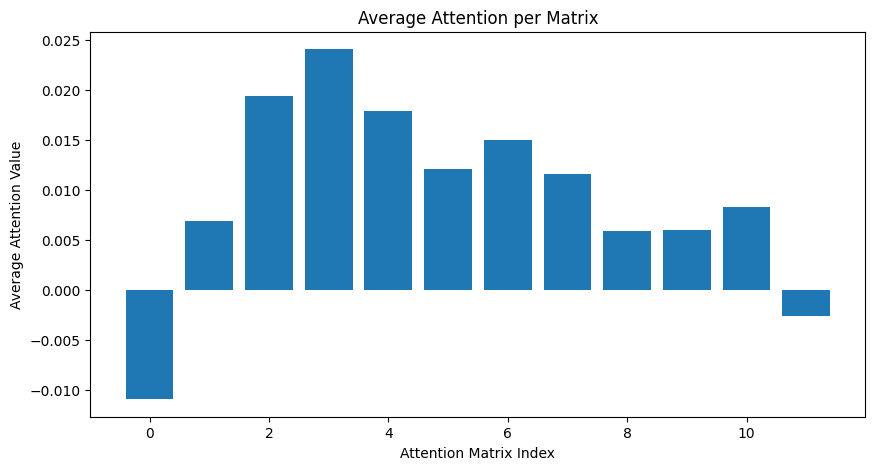

In [107]:
import matplotlib.pyplot as plt

def plot_attn_matrix(attn_matrices):
    if len(attn_matrices) > 0:
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(attn_matrices)), attn_matrices)
        plt.xlabel('Attention Matrix Index')
        plt.ylabel('Average Attention Value')
        plt.title('Average Attention per Matrix')
        plt.show()
    else:
        print("No attention matrices to display.")
img = get_img_from_url(url)
features = feature_extractor(dino, img)
attn_matrices = []
for feature in features:
    attn_matrix = feature[0].detach().cpu().numpy()
    attn_matrix = attn_matrix.mean() 
    attn_matrices.append(attn_matrix)

plot_attn_matrix(attn_matrices)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


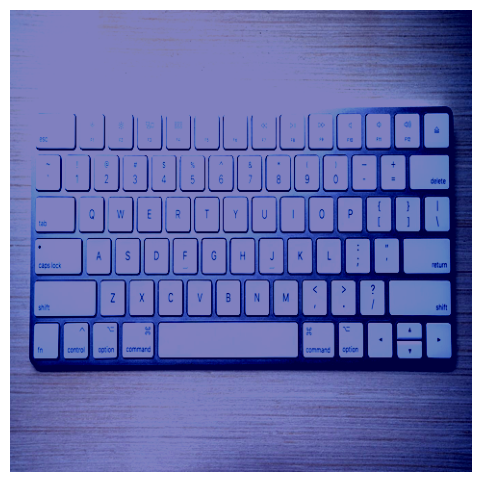

In [108]:
# Overlapp the attention matrix with the image (only the last block)
def plot_attn_matrix_with_image(attn_matrices, img_tensor):
    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    attn_matrix = attn_matrices[-1]
    attn_heatmap = np.resize(attn_matrix, (img_np.shape[0], img_np.shape[1]))
    attn_heatmap = attn_heatmap / attn_heatmap.max()
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np) 
    plt.imshow(attn_heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()
plot_attn_matrix_with_image(attn_matrices, img)
